In [289]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as pt
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [290]:
df = pd.read_csv('nlp_data_final.csv')
df.tail(3)

,Unnamed: 0,Unnamed: 0.1,Review,Rating
20345,7507,7507,Excellent must buy the product 🔥,4.0 out of 5 stars
20346,7508,7508,Yes,4.0 out of 5 stars
20347,7509,7509,You should go for it,4.0 out of 5 stars


### Checking duplicates

In [291]:
df.duplicated().sum()

0

In [292]:
df.drop_duplicates(inplace=True)

In [293]:
df.duplicated().sum()

0

In [294]:
df = df.reset_index()

### Checking Null values

In [295]:
df.isnull().sum()

index           0
Unnamed: 0      0
Unnamed: 0.1    0
Review          4
Rating          0
dtype: int64

In [296]:
df.dropna(inplace=True)

In [297]:
df.isnull().sum()

index           0
Unnamed: 0      0
Unnamed: 0.1    0
Review          0
Rating          0
dtype: int64

## Data Preprocessing

In [298]:
df.sample(5)

,index,Unnamed: 0,Unnamed: 0.1,Review,Rating
93,93,93,93,"I ordered this phone on 22 Feb at Sail day at Amazon. I received this phone, this Monday 28 Feb.\nTill now I am using this phone and very fond of.\nVery smooth operation, camera is also pretty good and Finger print senser is cool and fast.\n\nI am little bit disappointed fot battery life but yet due to giant charger it is manage to use.\n\nIn 35 minutes battery is fully charged.\n\nLove this phone. Over all good phone in this price range",4.0 out of 5 stars
7627,7627,7627,7627,This phone doesn't have 3.5 mm audio jack but its wrongly mentioned in the product specifications on amazon.,3.0 out of 5 stars
16222,16222,3384,3384,Not as expected.. but ok with the prize range. ..,4.0 out of 5 stars
4473,4473,4473,4473,It's not good quality.,1.0 out of 5 stars
10305,10305,10305,10305,Good and compact.,4.0 out of 5 stars


* Initial Observations - 
    Things which would have to be taken care off
    - We have letter's in mixed casing.
    - We have puntuations.
    - We have stopwords.
    - We see there are emoji's in the dataset.
    - We have Unnamed column's which are of no use, so we could drop them.

#### Unnamed

In [299]:
df.drop(['index','Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)
df.sample(3)

,Review,Rating
14806,Samsung galaxy note 8 wonderfull phone lookvise Display is good camera quality is amazing bettery backup is not good but I think it's adjustable,5.0 out of 5 stars
16761,I need to talk to technetion bcos its not connecting to my tv,5.0 out of 5 stars
1694,EVERYTHING IS BEST IN PHONE BUT IS BATTERY DRAINING TO FAST,5.0 out of 5 stars


### Rating
We just need the ratings and not the entire text. Let's keep just the rating and convert it into int format

In [300]:
for i in range(len(df)):
    try:
        df['Rating'][i] = df['Rating'][i].split('.')[0]
    except:
        pass

In [301]:
df['Rating'].value_counts()

5                     6222
1                     4710
4                     4618
3                     3152
2                     1624
-                       14
4.0 out of 5 stars       4
Name: Rating, dtype: int64

In [302]:
not_convrted = df[df['Rating']=='4.0 out of 5 stars'].index
not_convrted

Int64Index([20344, 20345, 20346, 20347], dtype='int64')

In [303]:
for i in not_convrted:
    df['Rating'][i] = df['Rating'][i].split('.')[0]

There are some Ratings missing and theres no way to predict them hence we could delete them as the number is too small for missing ratings.

In [304]:
df = df[df['Rating'] != '-']
df = df.reset_index()
df.drop('index',axis=1,inplace=True)
df.tail(2)

,Review,Rating
20328,Yes,4
20329,You should go for it,4


In [305]:
df['Rating'].value_counts()

5    6222
1    4710
4    4622
3    3152
2    1624
Name: Rating, dtype: int64

In [306]:
df['Rating'] = df['Rating'].astype('int')

In [307]:
df.dtypes

Review    object
Rating     int32
dtype: object

### Review

In [308]:
df['Text_Length'] = df['Review'].str.len()

In [309]:
df[9572:9578]

,Review,Rating,Text_Length
9572,Superb quality speakers I loved this product 👌 and Perfect for small home,5,73
9573,I am use in just 2 week and my experience my home like a cinema hall bass quality is best and valule for money,5,110
9574,"Packing good, delivery fast and price I got also good as I got it in 1899, but FM catching capability of this is horrible, otherwise it is good",3,143
9575,go for it sine product in good price,5,36
9576,ஓரளவுக்கு நல்லா தான் இருக்கு இந்த ரேட்டுக்கு best home theatre கம்ப்யூட்டர் லேப்டாப் யூஸ் பண்றவங்களுக்கு இது நல்லா இருக்கும்,3,124
9577,"Sound quality is very good, highs and bass is very good.Remote control is very handy. Connectivity is very nice.Value for money.",5,128


#### From above, we see that we have text which is not in english...Let's remove it

In [310]:
def remove_other_languages(text):
    pattern = re.compile('[^a-zA-Z]+')
    return pattern.sub(r' ',text)

In [311]:
df['Review'] = df['Review'].apply(remove_other_languages)

#### Replacing Emoji's with their meaning

In [312]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [313]:
df['Review'] = df['Review'].apply(remove_emojis)

#### Lower Casing

In [314]:
df['Review'] = df['Review'].str.lower()
df.sample(3)

,Review,Rating,Text_Length
6224,just buy it if you are planning to upgrade from older iphones like original se or iphone it s battery life is very good lasts me days given my usage is light to moderate must buy if you are looking for smaller phone,5,230
12273,not goood item tooo complaints,1,32
17602,very poor sound quality not worthy,1,35


#### Checking and removing HTML Tags

In [315]:
df[df['Review'].str.contains('</')]

,Review,Rating,Text_Length


In [316]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'',text)

In [317]:
df['Review'] = df['Review'].apply(remove_html_tags)

In [318]:
df[df['Review'].str.contains('</')]

,Review,Rating,Text_Length


#### Removing URLs

In [319]:
df[df['Review'].str.contains('http')]

,Review,Rating,Text_Length
5101,you have to chose the phone you need right get the link below for your latest model phone instantly https www amazon in b encoding utf tag bpavankumar linkcode ur linkid ce cda cf fb a b camp creative node,3,253
6525,new year and christmas day special status quotes wishes a href https www best status com best happy new year gif image html happy new year gif image a a href https www best status com happy christmas merry christmas status wishes for whatsapp html happy christmas status wishes for whatsapp a a href https www best status com happy christmas day hindi status html happy christmas day hindi status a a href https www best status com happy christmas status and merry html happy christmas status gif image picture a a href https www best status com happy new year and merry christmas html happy new year and merry christmas status a a href https www best status com romantic new year statusmassage html romantic new year status massage a a href https www best status com happy new year gifs animated image html happy new year gif image picture animated a a href https www best status com happy new year romantic love image html happy new year romantic love status a a href https www best status com happy new year shayari in hindi html happy new year shayari in hindi a a href https www best status com happy christmas day d gifs html happy christmas day d gifs a a href https www best status com best merry christmas status quotes html merry christmas status quotes a a href https www best status com merry christmas status happy christmas status quotes best merry christmas status saying html merry christmas status quotes saying a a href https www best status com top happy christmas day gifs html top happy christmas day gif images a a href https www best status com happy new year gif animated image html happy new year gif image picture a,5,1930
7274,very bad camera especially when did a x zoom the picture is highly pixelated instead of this pls prefer redmi note https amzn to fe y f,1,146


In [320]:
def remove_url(text):
    pattern = re.compile('http\S+')
    return pattern.sub(r'',text)

In [321]:
df['Review'] = df['Review'].apply(remove_url)

In [322]:
df[df['Review'].str.contains('http')]

,Review,Rating,Text_Length


#### Removing Punctuations

In [323]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [324]:
exclude = string.punctuation

In [325]:
def remove_punctuations(text):
    for char in exclude:
        text = text.replace(char,"")
    return text

In [326]:
df['Review'] = df['Review'].apply(remove_punctuations)

In [327]:
df.sample(3)

,Review,Rating,Text_Length
12792,quality and sound are doing great but why i didn t receive hmdi cable and optical cable when speaker support them,4,115
3543,actually i m android user now switched to iphone user experience is good but camera quality isn t meet my expectations when taken photos on day times and little low lights you ll get good quality photos night mode is worst battery is good for moderate users phone is very compact and display quality really awesome my conclusion if you looking for privacy and protect from hackers definitely iphone is safe those who are all moderate user and then buy this model,4,467
15051,very good product with super display fast delivery thank you to amazon,5,74


#### Removing Stopwords

In [328]:
from nltk.corpus import stopwords

In [329]:
stopwords_list = set(stopwords.words('English')+['samsung','iphone','oneplus','android','ios','speaker','phone','mobile','galaxy','home theatre','speakers','laptop','amazon','redmi','hp','dell','sony','jbl','chrome','sound','camera','battery','display','product','device','screen','quality','one'])
stopwords_list

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amazon',
 'an',
 'and',
 'android',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'battery',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'camera',
 'can',
 'chrome',
 'couldn',
 "couldn't",
 'd',
 'dell',
 'device',
 'did',
 'didn',
 "didn't",
 'display',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'galaxy',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'home theatre',
 'how',
 'hp',
 'i',
 'if',
 'in',
 'into',
 'ios',
 'iphone',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'jbl',
 'just',
 'laptop',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'mobile',
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 '

In [330]:
def remove_stopwords(text):
    new_text = []
    for words in text.split():
        if words in stopwords_list:
            new_text.append('')
        else:
            new_text.append(words)
    return " ".join(new_text)

In [331]:
df['Review'] = df['Review'].apply(remove_stopwords)

In [332]:
df.sample(5)

,Review,Rating,Text_Length
4645,get better beyond amazing,5,60
16986,bass effects less,3,21
14229,bought model offline exclusive store reaching home power button got failed somehow managed turn n r observations anti glare full hd kid joined online class suddenly flickering complaint raised entire shaking restart thrice frequent disconnect wifi using mbps speed internet important value money worst service provider series problem,2,509
6317,bought initially worked good past days geting heats even without using charging hets heats since carried year warranty manufacturing months warranty box accesories including request manifacturer replace said earliest,1,391
15197,good,2,22


### Removing Blank Reviews

In [333]:
df[df['Review']=='']

,Review,Rating,Text_Length
29,,5,1
226,,1,1
547,,1,276
583,,1,268
637,,4,1
...,...,...,...
19497,,2,7
19843,,4,58
19873,,4,12
20100,,4,3


In [334]:
len(df[df['Review']==''])

102

In [335]:
df = df[df['Review']!='']

In [336]:
df[df['Review']=='']

,Review,Rating,Text_Length


In [337]:
df = df.reset_index()
df.drop('index',axis=1,inplace=True)
df.tail(3)

,Review,Rating,Text_Length
20225,excellent must buy,4,32
20226,yes,4,3
20227,go,4,20


### Building a Word Cloud

In [338]:
from wordcloud import WordCloud

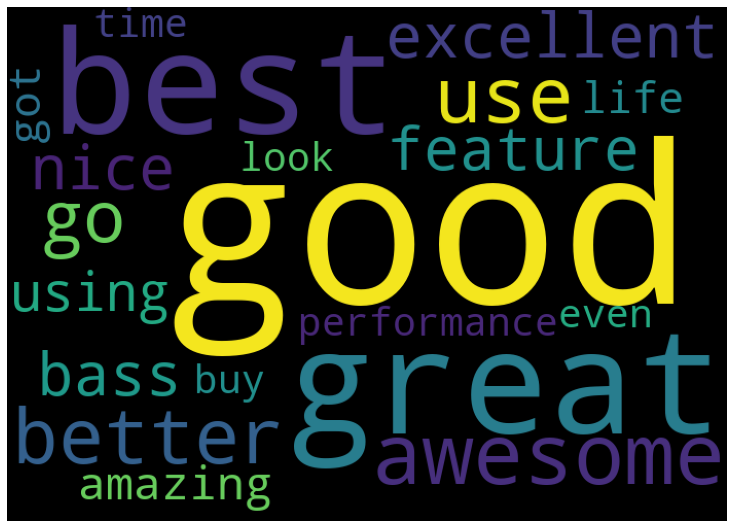

In [339]:
good_rating = df['Review'][df['Rating'] >= 4]

good_word_cloud = WordCloud(width=700,height=500,max_words=20).generate(' '.join (good_rating))
plt.figure(figsize=(10,8),facecolor='w')
plt.imshow(good_word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

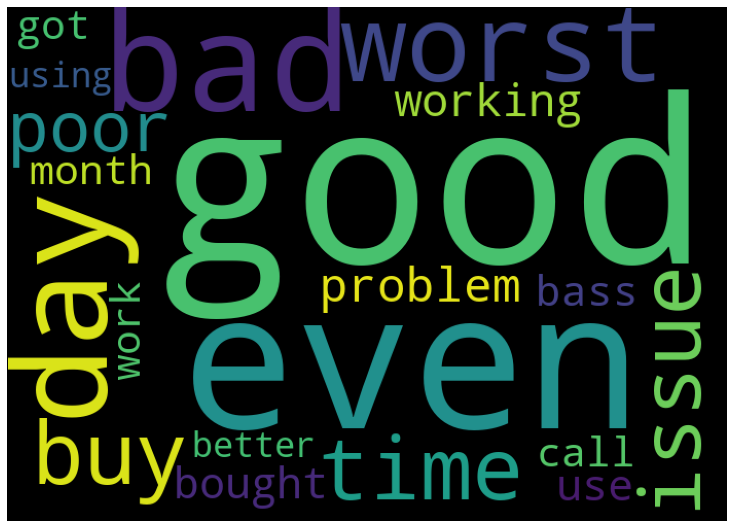

In [340]:
bad_rating = df['Review'][df['Rating'] <= 2]

bad_word_cloud = WordCloud(width=700,height=500,max_words=20).generate(' '.join (bad_rating))
plt.figure(figsize=(10,8),facecolor='w')
plt.imshow(bad_word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### Stemming

In [341]:
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [342]:
for i in tqdm(range(len(df))):
    text = df['Review'][i]
    document = []
    token = nltk.word_tokenize(text)
    for words in token:
        word = ps.stem(words)
        document.append(word)
    df['Review'][i] = ' '.join(document)

100%|███████████████████████████████████████████████████████████████████████████| 20228/20228 [00:55<00:00, 362.37it/s]


In [343]:
df.sample(5)

,Review,Rating,Text_Length
15439,best note smartphon,5,28
8719,excel price rang,4,38
963,averag day day usag,5,34
6266,expect worst experi might happi bought year back bad touch slog perform noth good,1,176
13857,bought today upon follow instruct start say moment contin hour noth els tri multipl time,1,185


In [344]:
df['Cleaned_Text_Length']=df['Review'].str.len()

In [345]:
df.sample(4)

,Review,Rating,Text_Length,Cleaned_Text_Length
7542,face problem sinc start day work good connect network properli voic disturb sever time majorli go auto switch time restart,3,212,122
6383,good budget younger suitabl low averag user multitask purpos pleas dont buy problem wifi speed wifi bluetooth run wifi internet speed slowdown resolut realli like mi cheap like th smartphon time realli disappoint,2,366,212
18967,coupl minut back unbox find littl damag shown dark shade howev visibl light,1,148,75
9219,connect usabl great like thing placement bass place bottom protect accident place sharp object diaphragm get punctur easili,4,284,123


In [346]:
Text_Length = df['Text_Length'].sum()
Cleaned_Text_Length = df['Cleaned_Text_Length'].sum()
Text_Length,Cleaned_Text_Length

(4003336, 2000580)

In [347]:
percent_data_reduced = (Text_Length-Cleaned_Text_Length)/Text_Length*100
percent_data_reduced

50.02717733410336

### Splitting the Dataset into train and test

In [60]:
X = df['Review']

In [61]:
y = df['Rating']

### Encoding: Bag Of Words

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(min_df=2)

In [63]:
x = cvec.fit_transform(X).toarray()

### Model Building

In [64]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
maxAccu=0
maxRS=0
for i in range(1,15):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    pred = LR.predict(x_test)
    acc = accuracy_score(y_test, pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is",maxAccu," on Random_state ",maxRS)

Best accuracy is 0.5275992750041193  on Random_state  11


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
model=[LogisticRegression(),MultinomialNB(),RandomForestClassifier()]
for m in model:
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=maxRS)  
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    print("*******************************************************************************")
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print('accuracy score of ->', m)
    print(accuracy_score(y_test,pred))
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("*******************************************************************************")

*******************************************************************************
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
accuracy score of -> LogisticRegression()
0.5275992750041193
[[ 982   82  126   79  111]
 [ 222   40  125   70   48]
 [ 232   49  249  218  163]
 [ 106   19  163  528  567]
 [  64   11   78  334 1403]]
              precision    recall  f1-score   support

           1       0.61      0.71      0.66      1380
           2       0.20      0.08      0.11       505
           3       0.34      0.27      0.30       911
           4       0.43      0.38      0.40      1383
           5       0.61      0.74      0.67      1890

    accuracy                           0.53      6069
   macro avg       0.44      0.44      0.43      6069
weighted avg       0.49      0.53      0.51      6069

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
*********************************************************************

#### Encoding : ngram

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(ngram_range=(1,2),max_features=30000,min_df=2)

In [68]:
x = cvec.fit_transform(X).toarray()

In [69]:
maxAccu=0
maxRS=0
for i in range(1,15):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=i)
    mnb = MultinomialNB()
    mnb.fit(x_train,y_train)
    predmnb = mnb.predict(x_test)
    acc = accuracy_score(y_test, predmnb)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is",maxAccu," on Random_state ",maxRS)

Best accuracy is 0.5432525951557093  on Random_state  11


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
model=[LogisticRegression(),MultinomialNB(),RandomForestClassifier()]
for m in model:
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=maxRS)  
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    print("*******************************************************************************")
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print('accuracy score of ->', m)
    print(accuracy_score(y_test,pred))
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("*******************************************************************************")

*******************************************************************************
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
accuracy score of -> LogisticRegression()
0.5257867853023562
[[ 964   79  150   94   93]
 [ 218   45  121   77   44]
 [ 204   49  270  255  133]
 [ 100   21  176  577  509]
 [  60   10   76  409 1335]]
              precision    recall  f1-score   support

           1       0.62      0.70      0.66      1380
           2       0.22      0.09      0.13       505
           3       0.34      0.30      0.32       911
           4       0.41      0.42      0.41      1383
           5       0.63      0.71      0.67      1890

    accuracy                           0.53      6069
   macro avg       0.44      0.44      0.44      6069
weighted avg       0.50      0.53      0.51      6069

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
*********************************************************************

### TFidf

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [72]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(X).toarray()

In [73]:
maxAccu=0
maxRS=0
for i in range(1,15):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    predrf = LR.predict(x_test)
    acc = accuracy_score(y_test, predrf)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is",maxAccu," on Random_state ",maxRS)

Best accuracy is 0.5562695666501895  on Random_state  9


In [74]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
model=[LogisticRegression(),KNeighborsClassifier(),MultinomialNB(),RandomForestClassifier(),AdaBoostClassifier(),ExtraTreesClassifier()]
for m in model:
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=maxRS)  
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    print("*******************************************************************************")
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print('accuracy score of ->', m)
    print(accuracy_score(y_test,pred))
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("*******************************************************************************")

*******************************************************************************
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
accuracy score of -> LogisticRegression()
0.5562695666501895
[[1089    6  144   79   94]
 [ 235   12  109   93   57]
 [ 244   10  244  254  162]
 [ 120    1  131  625  550]
 [  74    2   45  283 1406]]
              precision    recall  f1-score   support

           1       0.62      0.77      0.69      1412
           2       0.39      0.02      0.04       506
           3       0.36      0.27      0.31       914
           4       0.47      0.44      0.45      1427
           5       0.62      0.78      0.69      1810

    accuracy                           0.56      6069
   macro avg       0.49      0.46      0.44      6069
weighted avg       0.53      0.56      0.52      6069

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
*********************************************************************

### Word2Vec pre-trained Model

In [371]:
import gensim

In [372]:
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
from tqdm import tqdm

In [373]:
story = []
for doc in tqdm(df['Review']):
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        story.append(simple_preprocess(sent))

100%|██████████████████████████████████████████████████████████████████████████| 20205/20205 [00:03<00:00, 6099.16it/s]


In [374]:
model =gensim.models.Word2Vec(window=10,min_count=2,workers=8)

Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2022-08-17T06:47:02.311921', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [375]:
model.build_vocab(story)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
PROGRESS: at sentence #10000, processed 215476 words, keeping 8403 word types
PROGRESS: at sentence #20000, processed 339544 words, keeping 10915 word types
collected 10958 word types from a corpus of 341726 raw words and 20205 sentences
Creating a fresh vocabulary
Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 5669 unique words (51.73% of original 10958, drops 5289)', 'datetime': '2022-08-17T06:47:02.594278', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 336437 word corpus (98.45% of original 341726, drops 5289)', 'datetime': '2022-08-17T06:47:02.596273', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000

In [376]:
model.train(story, total_examples=model.corpus_count,epochs=model.epochs)

Word2Vec lifecycle event {'msg': 'training model with 8 workers on 5669 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-08-17T06:47:02.882524', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
EPOCH 0: training on 341726 raw words (298528 effective words) took 0.3s, 873728 effective words/s
EPOCH 1: training on 341726 raw words (298379 effective words) took 0.4s, 797133 effective words/s
EPOCH 2: training on 341726 raw words (298126 effective words) took 0.4s, 691027 effective words/s
EPOCH 3: training on 341726 raw words (298363 effective words) took 0.4s, 791211 effective words/s
EPOCH 4: training on 341726 raw words (298380 effective words) took 0.4s, 753054 effective words/s
Word2Vec lifecycle event {'msg': 'training on 1708630 raw words (1491776 effective words) took 2.1s, 710036 effective words/s', 'dat

(1491776, 1708630)

In [377]:
### Len of vocabulary // vector for vocabulary
len(model.wv.index_to_key)

5669

In [381]:
### Converting reviews to vector
def document_vector(doc):
    # remove out of vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc],axis=0)

In [395]:
document_vector(df['Review'].values[0])

array([ 0.09382379, -0.0968582 ,  0.38144696, -0.57621354,  0.03558198,
       -1.0852188 ,  0.6035317 ,  0.73482144, -0.05796165, -0.3767699 ,
        0.16583905, -0.26787215, -0.60375285, -0.10381859,  0.02438763,
        0.3174693 , -0.14494681, -0.06403251, -0.26004866,  0.27608994,
        0.6585306 , -0.0610157 ,  0.1811288 , -0.06131135,  0.68282723,
        0.52603406, -0.10811611, -0.597082  ,  0.02549524,  0.2877253 ,
       -0.16944791,  0.04527884, -0.48418158,  0.0307604 , -0.15077081,
       -0.16889267, -0.10418746,  0.29420477,  0.21380396, -0.2860117 ,
       -0.13967204, -0.01931567,  0.3692388 ,  0.3062664 ,  0.08052934,
        0.74369836, -0.1573765 ,  0.1369946 ,  0.50506926,  0.04183483,
       -0.04112903, -0.5417459 ,  0.7257353 ,  0.27173907, -0.92153525,
        0.36900172,  0.2397609 , -0.15609257, -0.40551537,  0.5231602 ,
       -0.40801954, -0.5640695 , -0.07684231,  0.4536441 , -0.6619997 ,
        0.9077455 , -0.5928496 ,  0.2356209 ,  0.40783882,  0.06

In [386]:
len(df[df['Review']==''])

0

In [593]:
df=df[df['Review']!='']
df.drop(20112,axis=0,inplace=True)
df = df.reset_index()
df.drop('index',axis=1,inplace=True)
df.tail(2)

,Review,Rating,Text_Length,Cleaned_Text_Length
20137,ye,4,3,2
20138,go,4,20,2


In [596]:
X = []
for doc in tqdm(df['Review'].values):
    X.append(document_vector(doc))

100%|██████████████████████████████████████████████████████████████████████████| 20139/20139 [00:05<00:00, 3731.85it/s]


In [597]:
maxAccu=0
maxRS=0
for i in range(1,15):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    predrf = LR.predict(x_test)
    acc = accuracy_score(y_test, predrf)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is",maxAccu," on Random_state ",maxRS)

Best accuracy is 0.5562695666501895  on Random_state  9


In [598]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
model=[LogisticRegression(),KNeighborsClassifier(),MultinomialNB(),RandomForestClassifier(),AdaBoostClassifier(),ExtraTreesClassifier()]
for m in model:
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=maxRS)  
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    print("*******************************************************************************")
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print('accuracy score of ->', m)
    print(accuracy_score(y_test,pred))
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("*******************************************************************************")

*******************************************************************************
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
accuracy score of -> LogisticRegression()
0.5562695666501895
[[1089    6  144   79   94]
 [ 235   12  109   93   57]
 [ 244   10  244  254  162]
 [ 120    1  131  625  550]
 [  74    2   45  283 1406]]
              precision    recall  f1-score   support

           1       0.62      0.77      0.69      1412
           2       0.39      0.02      0.04       506
           3       0.36      0.27      0.31       914
           4       0.47      0.44      0.45      1427
           5       0.62      0.78      0.69      1810

    accuracy                           0.56      6069
   macro avg       0.49      0.46      0.44      6069
weighted avg       0.53      0.56      0.52      6069

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
*********************************************************************

### Final Model

We have 2 models with the same accuracy :
   1. Word2Vec with Logistic Regression 
   2. TFIDF with Logistic Regression
   
We choose word2vec with Logistic Regression as our Final Model

In [599]:
model=[LogisticRegression()]
for m in model:
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=maxRS)  
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    print("*******************************************************************************")
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print('accuracy score of ->', m)
    print(accuracy_score(y_test,pred))
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("*******************************************************************************")

*******************************************************************************
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
accuracy score of -> LogisticRegression()
0.5562695666501895
[[1089    6  144   79   94]
 [ 235   12  109   93   57]
 [ 244   10  244  254  162]
 [ 120    1  131  625  550]
 [  74    2   45  283 1406]]
              precision    recall  f1-score   support

           1       0.62      0.77      0.69      1412
           2       0.39      0.02      0.04       506
           3       0.36      0.27      0.31       914
           4       0.47      0.44      0.45      1427
           5       0.62      0.78      0.69      1810

    accuracy                           0.56      6069
   macro avg       0.49      0.46      0.44      6069
weighted avg       0.53      0.56      0.52      6069

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
*********************************************************************

### Saving Final Model

In [600]:
import pickle

In [602]:
file_name = 'NLP_Rating_Prediction.pkl'
pickle.dump(LogisticRegression(),open(file_name,'wb'))